# Projeto Final Redes Neurais

<b> Alunos: </b> João Otávio de Ávila Nascimento, Emelyn Alves e Kayllanny Lara da Silva Oliveira
\
<b> Professor: </b> Daniel Cassar

In [279]:
import argparse
import os
from typing import List
from typing import Optional

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import torch
import pytorch_lightning as pl
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import optuna
from optuna import create_study, Trial
from optuna.integration import PyTorchLightningPruningCallback
from packaging import version

In [40]:
features = ['Soil_Quality', 'Seed_Variety', 'Fertilizer_Amount_kg_per_hectare', 'Sunny_Days', 'Rainfall_mm', 'Irrigation_Schedule']
target = ['Yield_kg_per_hectare']

df_teste = pd.read_csv("agricultural_yield_test.csv")
df_treino = pd.read_csv("agricultural_yield_train.csv")

df_teste = df_teste.reindex(features + target, axis=1)
df_teste = df_teste.dropna()

df_treino = df_treino.reindex(features + target, axis=1)
df_treino = df_treino.dropna()

In [41]:
df_teste

,Soil_Quality,Seed_Variety,Fertilizer_Amount_kg_per_hectare,Sunny_Days,Rainfall_mm,Irrigation_Schedule,Yield_kg_per_hectare
0,93.304721,0,132.522218,96.670922,602.386237,3,278.986563
1,83.674653,1,57.283997,99.007556,466.518251,8,836.434840
2,65.963033,1,227.895479,104.844272,510.320495,4,785.881787
3,78.692834,1,176.314126,90.136191,354.350914,5,807.884526
4,72.415684,1,160.070418,101.221668,443.993788,10,1064.542374
...,...,...,...,...,...,...,...
3995,95.094714,1,124.108262,98.970659,496.705800,5,802.209345
3996,53.256984,0,100.310322,111.448947,667.056391,8,509.646540
3997,94.145522,1,196.473704,110.003474,458.241408,3,776.013634
3998,61.452120,1,80.618357,97.815517,778.652540,4,502.319484


In [42]:
df_treino

,Soil_Quality,Seed_Variety,Fertilizer_Amount_kg_per_hectare,Sunny_Days,Rainfall_mm,Irrigation_Schedule,Yield_kg_per_hectare
0,96.415657,1,147.853040,94.593926,444.267569,3,683.759119
1,92.352626,0,281.565396,90.504644,517.585491,7,678.714861
2,63.714785,1,137.864940,97.329340,420.310945,8,934.691975
3,90.084256,1,100.946659,113.404828,547.817646,7,905.842541
4,81.600341,1,223.088908,83.048176,434.726333,6,897.584665
...,...,...,...,...,...,...,...
15995,77.053550,1,154.189768,103.115855,319.915079,7,956.781949
15996,99.795631,1,282.295839,123.598354,647.292136,4,879.682714
15997,67.478487,1,120.017122,102.308627,514.372747,8,932.829561
15998,85.176890,1,247.847389,114.956634,695.035801,6,889.738438


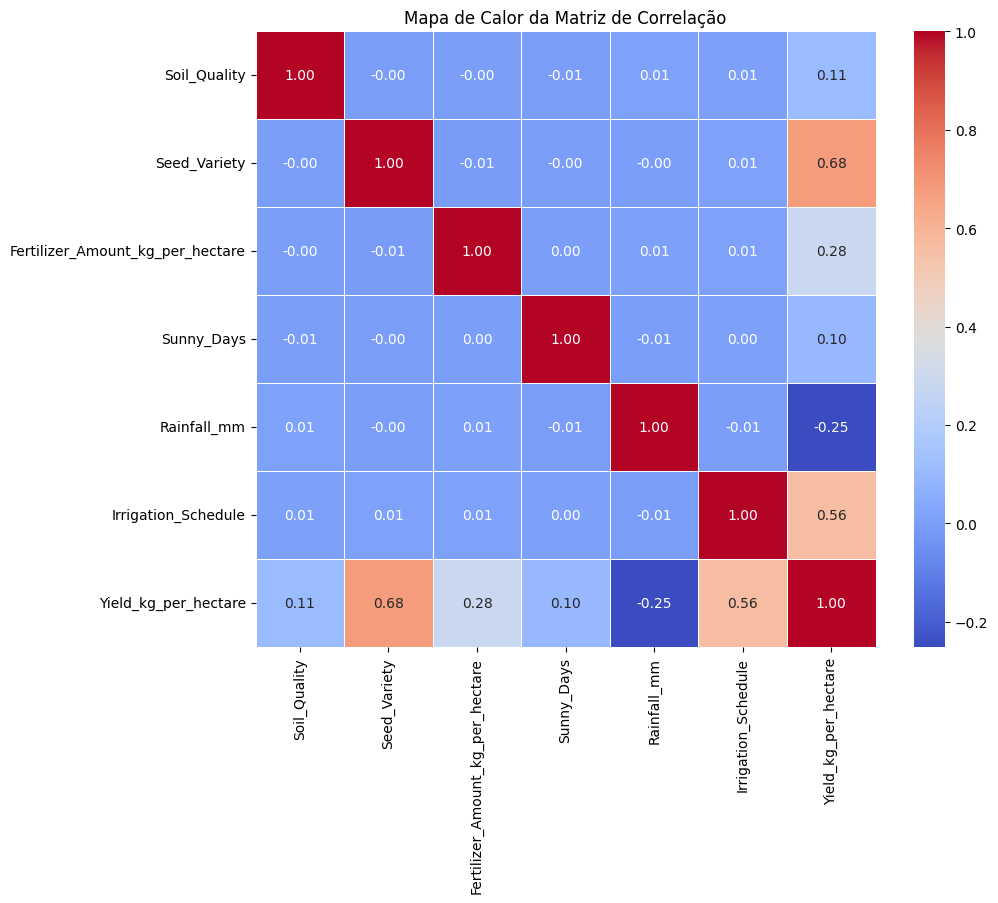

In [43]:
correlation_matrix = df_treino.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor da Matriz de Correlação')
plt.show()

In [44]:
TAMANHO_VALIDACAO = 0.1

SEMENTE_ALEATORIA = 61455

In [45]:
X_teste = df_teste.reindex(features, axis=1).values
y_teste = df_teste.reindex(target, axis=1).values

X_treino = df_treino.reindex(features, axis=1).values
y_treino = df_treino.reindex(target, axis=1).values

In [46]:
indices = df_treino.index
print(indices, len(indices))
indices_treino, indices_val = train_test_split(
    indices, test_size=TAMANHO_VALIDACAO, random_state=SEMENTE_ALEATORIA
)

print(indices_treino, len(indices_treino))
print()
print(indices_val, len(indices_val))

df_val = df_treino.loc[indices_val]
df_treino = df_treino.loc[indices_treino]


X_treino = df_treino.reindex(features, axis=1).values
y_treino = df_treino.reindex(target, axis=1).values

X_val = df_val.reindex(features, axis=1).values
y_val = df_val.reindex(target, axis=1).values

RangeIndex(start=0, stop=16000, step=1) 16000
Int64Index([ 2519, 11035,  3934, 14982,  4078, 12245, 12217,  9147, 11629,
             3768,
            ...
             6255,  7971, 13014,  6321, 12691,  2256, 10672,  6652, 11166,
            13937],
           dtype='int64', length=14400) 14400

Int64Index([ 8987,  4178,  4313,  1666,  6784, 12065, 10246,  8625,  9889,
             6176,
            ...
             4452, 12565, 12620, 13756, 14945,    97,  8368, 10148, 12993,
             5542],
           dtype='int64', length=1600) 1600


In [47]:
x_scaler = MaxAbsScaler()
x_scaler.fit(X_treino)

y_scaler = MaxAbsScaler()
y_scaler.fit(y_treino)

X_treino = x_scaler.transform(X_treino)
y_treino = y_scaler.transform(y_treino)

X_val = x_scaler.transform(X_val)
y_val = y_scaler.transform(y_val)

X_teste = x_scaler.transform(X_teste)
y_teste = y_scaler.transform(y_teste)

In [48]:
X_treino = torch.tensor(X_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_teste = torch.tensor(X_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

In [49]:
X_teste

tensor([[0.9331, 0.0000, 0.4418, 0.6788, 0.6905, 0.2000],
        [0.8368, 1.0000, 0.1910, 0.6952, 0.5348, 0.5333],
        [0.6596, 1.0000, 0.7597, 0.7362, 0.5850, 0.2667],
        ...,
        [0.9415, 1.0000, 0.6549, 0.7724, 0.5253, 0.2000],
        [0.6145, 1.0000, 0.2687, 0.6868, 0.8926, 0.2667],
        [0.5520, 0.0000, 0.4083, 0.6341, 0.6683, 0.2667]])

In [50]:
y_teste

tensor([[0.2014],
        [0.6039],
        [0.5674],
        ...,
        [0.5603],
        [0.3627],
        [0.1856]])

In [51]:
X_treino

tensor([[0.9795, 0.0000, 0.7640, 0.7867, 0.4237, 0.2000],
        [0.9797, 0.0000, 0.9775, 0.5857, 0.6576, 0.2667],
        [0.9986, 1.0000, 0.4590, 0.6481, 0.5381, 0.1333],
        ...,
        [0.6414, 1.0000, 0.9437, 0.7126, 0.5219, 0.3333],
        [0.6388, 1.0000, 0.4695, 0.6392, 0.3804, 0.2667],
        [0.9902, 1.0000, 0.5284, 0.7755, 0.6688, 0.3333]])

In [52]:
y_treino

tensor([[0.3213],
        [0.3385],
        [0.4438],
        ...,
        [0.6514],
        [0.4705],
        [0.5933]])

In [53]:
X_val

tensor([[0.6182, 1.0000, 0.3226, 0.7208, 0.6738, 0.5333],
        [0.9165, 0.0000, 0.1888, 0.6953, 0.4263, 0.0667],
        [0.6729, 1.0000, 0.5926, 0.7751, 0.6263, 0.2667],
        ...,
        [0.7481, 1.0000, 0.2723, 0.6990, 0.4905, 0.4667],
        [0.5995, 1.0000, 0.7954, 0.6793, 0.6092, 0.5333],
        [0.5068, 1.0000, 0.8737, 0.7273, 0.5378, 0.5333]])

In [54]:
y_val

tensor([[0.6336],
        [0.1526],
        [0.5981],
        ...,
        [0.5879],
        [0.7066],
        [0.6803]])

## Treinando a rede com uma arquitetura aleatória

In [55]:
class DataModule(L.LightningDataModule):
    def __init__(
        self,
        X_treino,
        y_treino,
        X_val,
        y_val,
        X_teste,
        y_teste,
        tamanho_lote = 256,
        num_trabalhadores = 2,
    ):
        super().__init__()

        self.tamanho_lote = tamanho_lote
        self.num_trabalhadores = num_trabalhadores

        self.X_treino = X_treino
        self.y_treino = y_treino
        self.X_val = X_val
        self.y_val = y_val
        self.X_teste = X_teste
        self.y_teste = y_teste

    def train_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_treino, self.y_treino),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

    def val_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_val, self.y_val),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

    def test_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_teste, self.y_teste),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

In [79]:
class MLP_teste(L.LightningModule):
    def __init__(
        self, num_dados_entrada, neuronios_c1, neuronios_c2, num_targets
    ):
        super().__init__()

        self.camadas = nn.Sequential(
            nn.Linear(num_dados_entrada, neuronios_c1),
            nn.Sigmoid(),
            nn.Linear(neuronios_c1, neuronios_c2),
            nn.Sigmoid(),
            nn.Linear(neuronios_c2, num_targets),
        )  
        

        self.fun_perda = F.mse_loss

        self.perdas_treino = []
        self.perdas_val = []

        self.curva_aprendizado_treino = []
        self.curva_aprendizado_val = []

    def forward(self, x):
        x = self.camadas(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("loss", loss, prog_bar=True)
        self.perdas_treino.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("val_loss", loss, prog_bar=True)
        self.perdas_val.append(loss)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("test_loss", loss)

        return loss

    def on_train_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_treino).mean()
        self.curva_aprendizado_treino.append(float(perda_media))
        self.perdas_treino.clear()

    def on_validation_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_val).mean()
        self.curva_aprendizado_val.append(float(perda_media))
        self.perdas_val.clear()

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=1e-3)
        return optimizer

In [67]:
NUM_EPOCAS = 20

treinador = L.Trainer(max_epochs=NUM_EPOCAS)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Precisamos também criar uma instância da classe `DataModule` que definimos acima.



In [68]:
dm = DataModule(X_treino, y_treino, X_val, y_val, X_teste, y_teste)

Antes de treinar, precisamos também criar uma instância da rede neural.



In [282]:
num_dados_de_entrada = 6
num_dados_de_saida = 1
neuronios_c1 = random.randint(1, 120)
neuronios_c2 = random.randint(1, 120)

mlp_teste = MLP_teste(
    num_dados_de_entrada, neuronios_c1, neuronios_c2, num_dados_de_saida
)

30


NameError: name 'MLP_teste' is not defined

Finalmente, temos tudo que precisamos. Podemos rodar o método `fit` do nosso treinador na nossa instância da rede neural, fornecendo também uma instância do `DataModule` como argumento.



In [72]:
treinador.fit(mlp_teste, dm)


  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 32    
---------------------------------------
32        Trainable params
0         Non-trainable params
32        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

c:\venv\ilumpy\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.


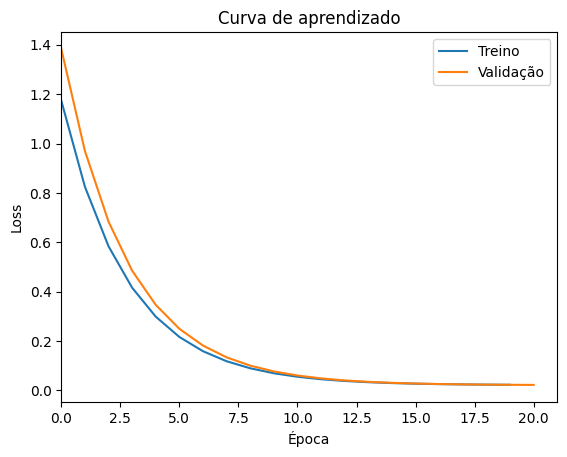

In [73]:
figura, eixo = plt.subplots()

ca_treino = mlp_teste.curva_aprendizado_treino
ca_val = mlp_teste.curva_aprendizado_val

eixo.plot(ca_treino, label="Treino")
eixo.plot(ca_val, label="Validação")

eixo.legend()

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Loss")

## Testando a rede com a arquitetura aleatória

Antes de testar a rede neural que treinamos precisamos deixá-la no modo de avaliação.



In [74]:
minha_mlp.eval()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=6, out_features=3, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=3, out_features=2, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=2, out_features=1, bias=True)
  )
)

Antes de computar a métrica, temos que configurar a instância do `DataModule` no modo teste, criar um ambiente onde não computamos os gradientes locais (ambiente `no_grad`), computar os valores previstos do target e, finalmente, desnormalizar os dados com o `inverse_transform`.



In [78]:
dm.setup("test")

with torch.no_grad():
    X_true = dm.X_teste

    y_true = dm.y_teste
    y_true = y_scaler.inverse_transform(y_true)

    y_pred = minha_mlp(X_true)
    y_pred = y_scaler.inverse_transform(y_pred)

    RMSE = mean_squared_error(y_true, y_pred, squared=False)

    print(RMSE)

203.8281770691316


## Treinando diferentes MLPs

Hiperparâmetros: neurônios (cada camada), camadas e dropout.

In [200]:
class MLP(L.LightningModule):
    def __init__(
        self, num_dados_entrada, num_targets, neuronios, dropouts
    ):
        super().__init__()    
        
        camadas = []   
        
        neuronios = [num_dados_entrada]+neuronios
    
        for k in range(len(neuronios)-1):
            camadas.append(nn.Linear(neuronios[k], neuronios[k+1]))
            camadas.append(nn.ReLU())
            camadas.append(nn.Dropout(dropouts[k]))
        
        camadas.append(nn.Linear(neuronios[-1], 1))
        
        self.camadas = nn.Sequential(*camadas) 
        

        self.fun_perda = F.mse_loss

        self.perdas_treino = []
        self.perdas_val = []

        self.curva_aprendizado_treino = []
        self.curva_aprendizado_val = []

    def forward(self, x):
        x = self.camadas(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("loss", loss, prog_bar=True)
        self.perdas_treino.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("val_loss", loss, prog_bar=True)
        self.perdas_val.append(loss)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("test_loss", loss)

        return loss

    def on_train_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_treino).mean()
        self.curva_aprendizado_treino.append(float(perda_media))
        self.perdas_treino.clear()

    def on_validation_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_val).mean()
        self.curva_aprendizado_val.append(float(perda_media))
        self.perdas_val.clear()

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=1e-3)
        return optimizer

In [265]:
def objective(trial: optuna.trial.Trial) -> float:
    
    MAX_EPOCHS = 100

    # We optimize the number of layers, hidden units in each layer and dropouts.
    num_dados_entrada = 6
    num_targets = 1
    
    neuronios = []   
    dropouts = []
    
    n_camadas = trial.suggest_int("n_layers", 1, 5)
        
    for i in range(n_camadas):
        neuronio = trial.suggest_int(f'n_units{i}', 4, 120)
        neuronios.append(neuronio)
        dropout = trial.suggest_float("dropout", 0.2, 0.5)
        dropouts.append(dropout)
        
    print(neuronios, dropouts)

    model = MLP(num_dados_entrada, num_targets, neuronios, dropouts)
    datamodule = DataModule(X_treino, y_treino, X_val, y_val, X_teste, y_teste)
    
    early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=3)
    treinador= L.Trainer(max_epochs=MAX_EPOCHS, callbacks=[early_stop_callback]) 
    
    treinador.fit(model, datamodule=datamodule)

    return trainer.callback_metrics["val_loss"].item()

[I 2024-05-16 09:22:13,892] A new study created in memory with name: no-name-0bfdfca6-57fb-4261-9903-cbfec566386c
GPU available: False, used: False


[54, 80, 106, 72] [0.43261592689633366, 0.43261592689633366, 0.43261592689633366, 0.43261592689633366]


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 21.1 K
---------------------------------------
21.1 K    Trainable params
0         Non-trainable params
21.1 K    Total params
0.085     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=2` reached.
[I 2024-05-16 09:22:34,191] Trial 0 finished with value: 0.10472174733877182 and parameters: {'n_layers': 4, 'n_units0': 54, 'dropout': 0.43261592689633366, 'n_units1': 80, 'n_units2': 106, 'n_units3': 72}. Best is trial 0 with value: 0.10472174733877182.
GPU available: False, used: False


Best trial:
  Value: 0.10472174733877182
  Params: 
    n_layers: 4
    n_units0: 54
    dropout: 0.43261592689633366
    n_units1: 80
    n_units2: 106
    n_units3: 72
dict_keys(['n_layers', 'n_units0', 'dropout', 'n_units1', 'n_units2', 'n_units3'])
['n_units0', 'n_units1', 'n_units2', 'n_units3']
[0.43261592689633366, 0.43261592689633366, 0.43261592689633366, 0.43261592689633366]


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 21.1 K
---------------------------------------
21.1 K    Trainable params
0         Non-trainable params
21.1 K    Total params
0.085     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=3` reached.


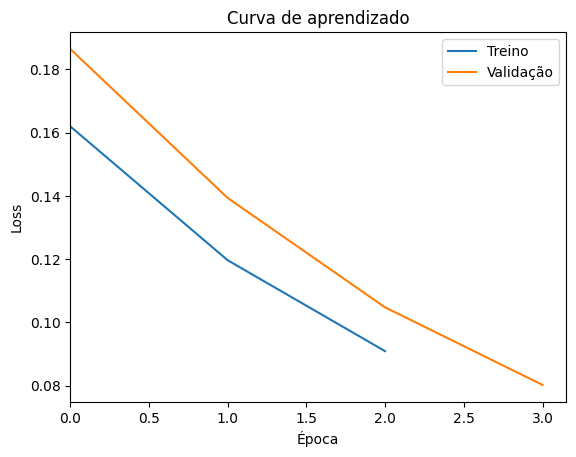

In [276]:
N_TRIALS = 150
num_dados_entrada = 6
num_targets = 1

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=N_TRIALS)

    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    # Criar DataModule
    datamodule = DataModule(X_treino, y_treino, X_val, y_val, X_teste, y_teste)

    # Extrair os dataloaders do DataModule
    train_dataloader = datamodule.train_dataloader()
    val_dataloader = datamodule.val_dataloader()
    test_dataloader = datamodule.test_dataloader()
    
#   print(trial.params.keys())
 
    camadas = [key for key in trial.params.keys() if key.startswith('n_units')]
    
    neuronios = []
    
    for k in camadas:
        neuronios.append(trial.params[f'{k}'])
    
    dropouts = [trial.params.get('dropout')] * len(camadas)
    
#   print(camadas)
#   print(dropouts)
    
    # Criar o modelo com os parâmetros do melhor teste
    melhor_modelo = MLP(num_dados_entrada, num_targets, neuronios, dropouts)

    # Treinar o modelo com o Trainer
    treinador = L.Trainer(max_epochs=3)
    treinador.fit(melhor_modelo, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
    
    # Plot treino e validação
    
    figura, eixo = plt.subplots()

    ca_treino_melhor_modelo = melhor_modelo.curva_aprendizado_treino
    ca_val_melhor_modelo = melhor_modelo.curva_aprendizado_val

    eixo.plot(ca_treino_melhor_modelo, label="Treino")
    eixo.plot(ca_val_melhor_modelo, label="Validação")

    eixo.legend()

    eixo.set_xlim(left=0)

    eixo.set_title("Curva de aprendizado")
    eixo.set_xlabel("Época")
    eixo.set_ylabel("Loss")

## Testando o melhor modelo encontrado

Antes de testar a rede neural que treinamos precisamos deixá-la no modo de avaliação.



In [74]:
melhor_modelo.eval()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=6, out_features=3, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=3, out_features=2, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=2, out_features=1, bias=True)
  )
)

Antes de computar a métrica, temos que configurar a instância do `DataModule` no modo teste, criar um ambiente onde não computamos os gradientes locais (ambiente `no_grad`), computar os valores previstos do target e, finalmente, desnormalizar os dados com o `inverse_transform`.



In [78]:
datamodule.setup("test")

with torch.no_grad():
    X_true = datamodule.X_teste

    y_true = datamodule.y_teste
    y_true = y_scaler.inverse_transform(y_true)

    y_pred = melhor_modelo(X_true)
    y_pred = y_scaler.inverse_transform(y_pred)

    RMSE = mean_squared_error(y_true, y_pred, squared=False)

    print(RMSE)

203.8281770691316


## Playground

In [272]:
dic = {'n_layers': 2, 'n_units0': 100, 'dropout': 0.28392562152905326, 'n_units1': 66}

#len(dic)

# n_units_keys = [key for key in dic.keys() if key.startswith('n_units')]

# for k in n_units_keys:
#     print(dic[f'{k}'])


# dic[list(dic.keys())[1]]

# dic.get('dropout')

# l = [3] * 3
# l

[3, 3, 3]

In [277]:
# num_dados_de_entrada = 6
# num_dados_de_saida = 1
   
# minha_mlp = MLP(num_dados_de_entrada, num_dados_de_saida, [2, 5, 4])
    
# minha_mlp

def objective(trial):
    num_dados_entrada = 6
    num_targets = 1
    camadas = []   
    
    n_camadas = trial.suggest_int("n_layers", 1, 5)
    print('camadas=', n_camadas)
        
    for i in range(n_camadas):
        neuronio = trial.suggest_int(f'n_units{i}', 4, 120, log=True)
        camadas.append(neuronio)
        
    
    
        print(f"Layer {i+1}:")
        print(f"Saida: {neuronio}")
        print(camadas)
        print()
        print()
    
    camadas_seq = []   
    
    for k in range(len(camadas)-1):
        camadas_seq.append(nn.Linear(camadas[k], camadas[k+1]))
        camadas_seq.append(nn.Sigmoid())
        
    camadas_seq.append(nn.Linear(camadas[-1], 1))
    camadas_seq = nn.Sequential(*camadas_seq)
    print('sequential->', camadas_seq)
    
    return camadas

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")



[I 2024-05-16 13:14:17,661] A new study created in memory with name: no-name-fb25d6ed-d5ea-4147-b66b-c9d643581198
[W 2024-05-16 13:14:17,777] Trial 0 failed because of the following error: The number of the values 4 did not match the number of the objectives 1.
[W 2024-05-16 13:14:17,793] Trial 1 failed because of the following error: The number of the values 5 did not match the number of the objectives 1.
[W 2024-05-16 13:14:17,811] Trial 2 failed because of the following error: The number of the values 3 did not match the number of the objectives 1.
[W 2024-05-16 13:14:17,831] Trial 3 failed because of the following error: The number of the values 5 did not match the number of the objectives 1.
[I 2024-05-16 13:14:17,843] Trial 4 finished with value: 107.0 and parameters: {'n_layers': 1, 'n_units0': 107}. Best is trial 4 with value: 107.0.
[W 2024-05-16 13:14:17,861] Trial 5 failed because of the following error: The number of the values 2 did not match the number of the objectives 1

camadas= 4
Layer 1:
Saida: 4
[4]


Layer 2:
Saida: 4
[4, 4]


Layer 3:
Saida: 45
[4, 4, 45]


Layer 4:
Saida: 22
[4, 4, 45, 22]


sequential-> Sequential(
  (0): Linear(in_features=4, out_features=4, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=4, out_features=45, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=45, out_features=22, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=22, out_features=1, bias=True)
)
camadas= 5
Layer 1:
Saida: 32
[32]


Layer 2:
Saida: 4
[32, 4]


Layer 3:
Saida: 4
[32, 4, 4]


Layer 4:
Saida: 34
[32, 4, 4, 34]


Layer 5:
Saida: 5
[32, 4, 4, 34, 5]


sequential-> Sequential(
  (0): Linear(in_features=32, out_features=4, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=4, out_features=34, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=34, out_features=5, bias=True)
  (7): Sigmoid()
  (8): Linear(in_features=5, out_features=1, bias=True)
)
camadas= 3
Layer